# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9355738 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('UFI', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9355738 non-null  float64
 1   high    9355738 non-null  float64
 2   low     9355738 non-null  float64
 3   close   9355738 non-null  float64
 4   volume  9355738 non-null  float64
 5   sector  9355738 non-null  object 
dtypes: float64(5), object(1)
memory usage: 464.7+ MB


In [9]:
len(prices.index.unique('ticker'))

2165

## Remove stocks with less than ten years of data

In [10]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8707837 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('UFI', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    8707837 non-null  float64
 1   high    8707837 non-null  float64
 2   low     8707837 non-null  float64
 3   close   8707837 non-null  float64
 4   volume  8707837 non-null  float64
 5   sector  8707837 non-null  object 
dtypes: float64(5), object(1)
memory usage: 432.5+ MB


In [12]:
len(prices.index.unique('ticker'))

1722

## Add some Basic Factors

### Compute the Relative Strength Index

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

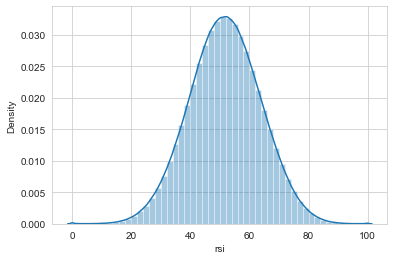

In [14]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8707837 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('UFI', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     8707837 non-null  float64
 1   high     8707837 non-null  float64
 2   low      8707837 non-null  float64
 3   close    8707837 non-null  float64
 4   volume   8707837 non-null  float64
 5   sector   8707837 non-null  object 
 6   rsi      8683729 non-null  float64
 7   bb_high  8675119 non-null  float64
 8   bb_mid   8675119 non-null  float64
 9   bb_low   8675119 non-null  float64
dtypes: float64(9), object(1)
memory usage: 956.3+ MB


In [18]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,8.675119e+06,8.675119e+06,8.675119e+06
mean,2.936089e+00,2.862929e+00,2.789769e+00
std,1.001374e+00,1.004042e+00,1.010473e+00
min,9.950331e-03,9.950331e-03,-1.568426e+00
25%,2.291790e+00,2.213369e+00,2.133726e+00
50%,2.928385e+00,2.855487e+00,2.784200e+00
75%,3.539303e+00,3.470217e+00,3.403694e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


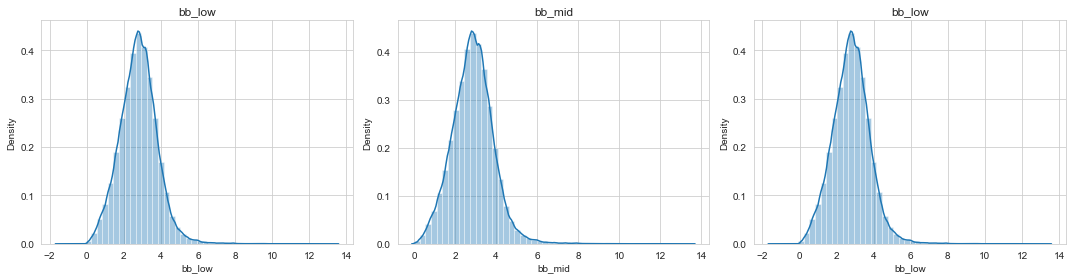

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [20]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

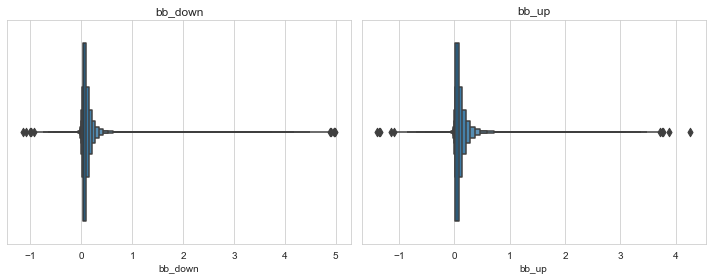

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [22]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [23]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [24]:
prices['atr'] = by_ticker.apply(compute_atr)

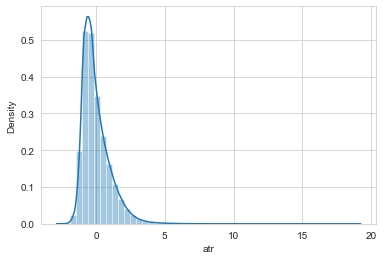

In [25]:
sns.distplot(prices.atr);

In [26]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

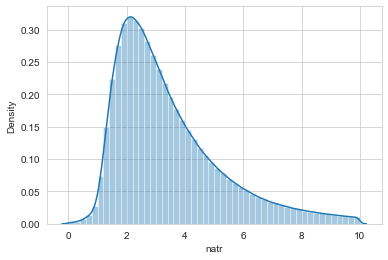

In [27]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

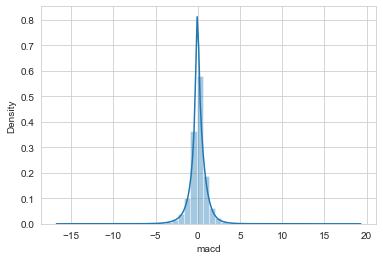

In [29]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [30]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [31]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [32]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8707837 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('UFI', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           8707837 non-null  float64
 1   high           8707837 non-null  float64
 2   low            8707837 non-null  float64
 3   close          8707837 non-null  float64
 4   volume         8707837 non-null  float64
 5   sector         8707837 non-null  object 
 6   rsi            8683729 non-null  float64
 7   bb_high        8675119 non-null  float64
 8   bb_mid         8675119 non-null  float64
 9   bb_low         8675119 non-null  float64
 10  bb_up          8675119 non-null  float64
 11  bb_down        8675119 non-null  float64
 12  atr            8683729 non-null  float64
 13  natr           8683729 non-null  float64
 14  macd           8651011 non-null  float64
 15  dollar_volume  8707837 non

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [33]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [34]:
prices = prices.unstack('ticker')

In [35]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 413370 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('UFI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  413370 non-null  float64
 1   atr            413370 non-null  float64
 2   bb_down        413370 non-null  float64
 3   bb_high        413370 non-null  float64
 4   bb_low         413370 non-null  float64
 5   bb_mid         413370 non-null  float64
 6   bb_up          413370 non-null  float64
 7   close          413370 non-null  float64
 8   macd           413370 non-null  float64
 9   natr           413370 non-null  float64
 10  rsi            413370 non-null  float64
 11  sector         413370 non-null  object 
dtypes: float64(11), object(1)
memory usage: 39.5+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [37]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

In [38]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [39]:
len(data.index.unique('ticker'))

908

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [40]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [41]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 202743 entries, ('AAPL', Timestamp('1996-02-29 00:00:00')) to ('UFI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   202743 non-null  float64
 1   return_3m   200928 non-null  float64
 2   return_6m   198212 non-null  float64
 3   return_12m  192810 non-null  float64
dtypes: float64(4)
memory usage: 7.0+ MB


In [42]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,202743.000000,200928.000000,198212.000000,192810.000000
mean,0.007409,0.004989,0.004396,0.004252
std,0.086813,0.051447,0.037601,0.027593
min,-0.275361,-0.180373,-0.134558,-0.093586
25%,-0.012020,-0.003324,-0.000614,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.033281,0.023888,0.018990,0.015527
max,0.334592,0.182711,0.134898,0.103482


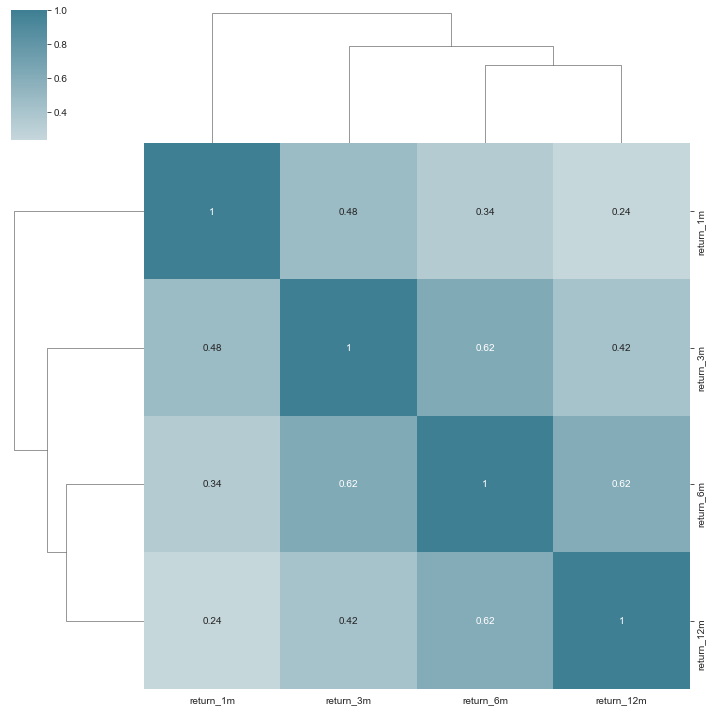

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [44]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121521 entries, ('AAPL', Timestamp('1997-01-31 00:00:00')) to ('UDR', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         121521 non-null  float64
 1   bb_down     121521 non-null  float64
 2   bb_high     121521 non-null  float64
 3   bb_low      121521 non-null  float64
 4   bb_mid      121521 non-null  float64
 5   bb_up       121521 non-null  float64
 6   macd        121521 non-null  float64
 7   natr        121521 non-null  float64
 8   rsi         121521 non-null  float64
 9   sector      121521 non-null  object 
 10  return_1m   121521 non-null  float64
 11  return_3m   121521 non-null  float64
 12  return_6m   121521 non-null  float64
 13  return_12m  121521 non-null  float64
dtypes: float64(13), object(1)
memory usage: 13.5+ MB


In [45]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [46]:
len(data.index.unique('ticker'))

625

We are left with 613 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 1995-01-31 to 2021-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  315 non-null    float64
 1   SMB     315 non-null    float64
 2   HML     315 non-null    float64
 3   RMW     315 non-null    float64
 4   CMA     315 non-null    float64
dtypes: float64(5)
memory usage: 14.8 KB


In [48]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115557 entries, ('A', Timestamp('2001-12-31 00:00:00', freq='M')) to ('UDR', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115557 non-null  float64
 1   SMB        115557 non-null  float64
 2   HML        115557 non-null  float64
 3   RMW        115557 non-null  float64
 4   CMA        115557 non-null  float64
 5   return_1m  115557 non-null  float64
dtypes: float64(6)
memory usage: 5.8+ MB


In [49]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115557.000000,115557.000000,115557.000000,115557.000000,115557.000000,115557.000000
mean,0.006170,0.002271,0.001919,0.003340,0.002420,0.005637
std,0.044299,0.031504,0.031266,0.029264,0.021485,0.093680
min,-0.172300,-0.148900,-0.111200,-0.184800,-0.068600,-0.388860
25%,-0.019700,-0.016900,-0.015100,-0.011600,-0.010600,-0.044413
50%,0.011700,0.001100,0.000200,0.004200,-0.000200,0.002648
75%,0.034900,0.022700,0.018000,0.014100,0.014300,0.051400
max,0.113500,0.180800,0.125800,0.133800,0.095600,0.506892


In [50]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [51]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,78685.000000,78685.000000,78685.000000,78685.000000,78685.000000,115557.000000
mean,0.073027,0.226600,0.105625,-0.003404,-0.007940,0.268220
std,0.489756,0.603368,0.816141,0.885050,0.987482,1.391089
min,-1.825339,-1.966124,-4.065352,-4.853710,-5.205895,-9.588326
25%,-0.257202,-0.180031,-0.415501,-0.489164,-0.555117,-0.106819
50%,0.049634,0.175815,0.056783,0.056799,0.042451,0.000000
75%,0.383480,0.583573,0.587879,0.552455,0.591722,0.856285
max,2.073125,4.498941,4.720304,4.109938,5.286068,10.652487


In [52]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,78685.000000,78685.000000,78685.000000,78685.000000,78685.000000,115557.000000
mean,0.073027,0.226600,0.105625,-0.003404,-0.007940,0.268220
std,0.489756,0.603368,0.816141,0.885050,0.987482,1.391089
min,-1.825339,-1.966124,-4.065352,-4.853710,-5.205895,-9.588326
25%,-0.257202,-0.180031,-0.415501,-0.489164,-0.555117,-0.106819
50%,0.049634,0.175815,0.056783,0.056799,0.042451,0.000000
75%,0.383480,0.583573,0.587879,0.552455,0.591722,0.856285
max,2.073125,4.498941,4.720304,4.109938,5.286068,10.652487


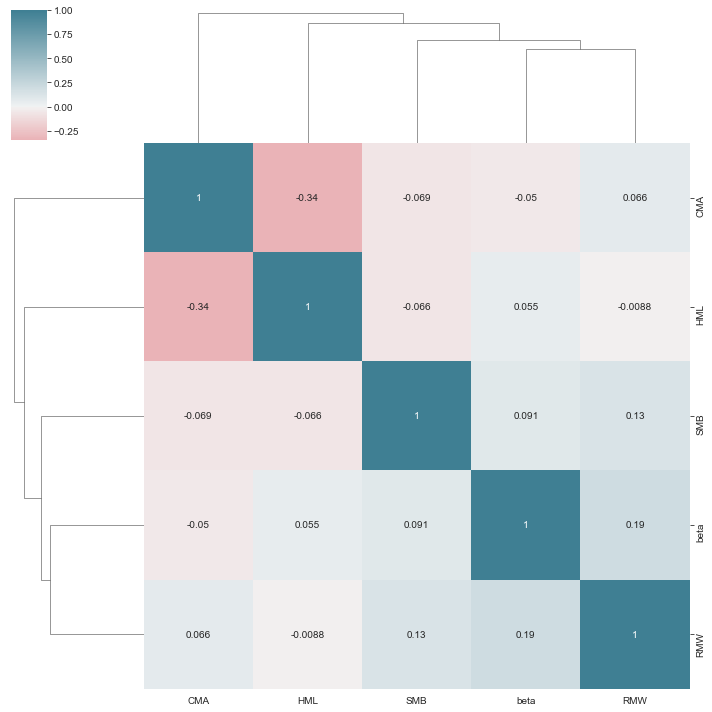

In [53]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [54]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78060 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('UDR', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         78060 non-null  float64
 1   bb_down     78060 non-null  float64
 2   bb_high     78060 non-null  float64
 3   bb_low      78060 non-null  float64
 4   bb_mid      78060 non-null  float64
 5   bb_up       78060 non-null  float64
 6   macd        78060 non-null  float64
 7   natr        78060 non-null  float64
 8   rsi         78060 non-null  float64
 9   sector      78060 non-null  object 
 10  return_1m   78060 non-null  float64
 11  return_3m   78060 non-null  float64
 12  return_6m   78060 non-null  float64
 13  return_12m  78060 non-null  float64
 14  beta        78060 non-null  float64
 15  SMB         78060 non-null  float64
 16  HML         78060 non-null  float64
 17  RMW         78060 non-null  float

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [56]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [57]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [58]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [59]:
data = data.dropna()

In [60]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77435 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('UDR', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77435 non-null  float64
 1   bb_down        77435 non-null  float64
 2   bb_high        77435 non-null  float64
 3   bb_low         77435 non-null  float64
 4   bb_mid         77435 non-null  float64
 5   bb_up          77435 non-null  float64
 6   macd           77435 non-null  float64
 7   natr           77435 non-null  float64
 8   rsi            77435 non-null  float64
 9   sector         77435 non-null  object 
 10  return_1m      77435 non-null  float64
 11  return_3m      77435 non-null  float64
 12  return_6m      77435 non-null  float64
 13  return_12m     77435 non-null  float64
 14  beta           77435 non-null  float64
 15  SMB            77435 non-null  float64
 16  HML            77435

## Sector Breakdown

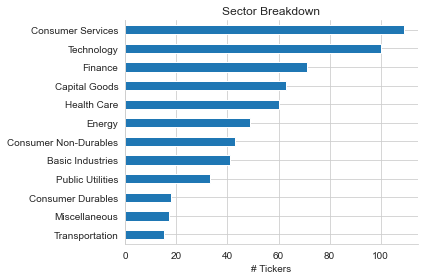

In [61]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [62]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [63]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [ ]:
mi = mutual_info_regression(X=X, y=data.target)

In [ ]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

In [ ]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [ ]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

In [ ]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [ ]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)